## Dogs v Cats

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *

In [2]:
PATH = "data/dogscats/"
sz = 224
arch = resnet34
bs = 64

In [3]:
m = arch(True)

In [4]:
m

ResNet(
  (conv1): Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNo

In [5]:
m = nn.Sequential(*children(m)[:-2], 
                  nn.Conv2d(512, 2, 3, padding=1), 
                  nn.AdaptiveAvgPool2d(1), Flatten(), 
                  nn.LogSoftmax())

In [6]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)

In [7]:
learn = ConvLearner.from_model_data(m, data)

In [8]:
learn.freeze_to(-4)

In [9]:
m[-1].trainable

True

In [10]:
m[-4].trainable

True

In [11]:
learn.fit(0.01, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      0.166655   0.181057   0.986328  



[0.18105714, 0.986328125]

In [12]:
learn.fit(0.01, 1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      0.08389    0.130175   0.989746  



[0.13017476, 0.98974609375]

## CAM

In [13]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = to_np(output)
    def remove(self): self.hook.remove()

In [14]:
x,y = next(iter(data.val_dl))
x,y = x[None,1], y[None,1]

vx = Variable(x.cuda(), requires_grad=True)

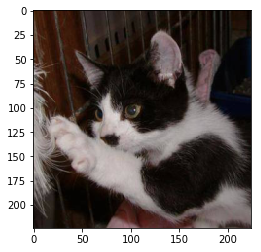

In [15]:
dx = data.val_ds.denorm(x)[0]
plt.imshow(dx);

In [16]:
sf = SaveFeatures(m[-4])
py = m(Variable(x.cuda()))
sf.remove()

py = np.exp(to_np(py)[0]); py

array([1., 0.], dtype=float32)

In [17]:
feat = np.maximum(0, sf.features[0])
feat.shape

(2, 7, 7)

In [18]:
f2=np.dot(np.rollaxis(feat,0,3), py)
f2-=f2.min()
f2/=f2.max()
f2

array([[0.20497, 0.33996, 0.34533, 0.26596, 0.18523, 0.16471, 0.12614],
       [0.2898 , 0.56735, 0.6646 , 0.56067, 0.39082, 0.27543, 0.19791],
       [0.31014, 0.71454, 0.93985, 0.8496 , 0.60523, 0.36014, 0.19927],
       [0.20404, 0.65736, 1.     , 0.98709, 0.71563, 0.42088, 0.20198],
       [0.05442, 0.47846, 0.81374, 0.8318 , 0.54995, 0.30191, 0.12207],
       [0.     , 0.19086, 0.48717, 0.49896, 0.27601, 0.1194 , 0.04651],
       [0.     , 0.     , 0.13671, 0.12266, 0.     , 0.     , 0.     ]], dtype=float32)

/home/jchoo/miniconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


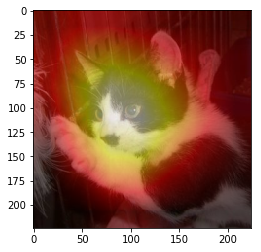

In [19]:
plt.imshow(dx)
plt.imshow(scipy.misc.imresize(f2, dx.shape), alpha=0.5, cmap='hot');

## Model

In [20]:
learn.unfreeze()
learn.bn_freeze(True)

In [21]:
lr=np.array([1e-6,1e-4,1e-2])

In [22]:
learn.fit(lr, 2, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      0.069238   0.123709   0.989746  
    1      0.079704   0.119636   0.989746  



[0.119636014, 0.98974609375]

In [26]:
#accuracy_np(*learn.TTA())
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds),axis=0)
accuracy_np(probs, y)

0.9915

In [30]:
learn.fit(lr, 2, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      0.081188   0.122757   0.989746  
    1      0.118377   0.118888   0.989258  



[0.118888214, 0.9892578125]

In [31]:
#accuracy(*learn.TTA())
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds),axis=0)
accuracy_np(probs, y)

0.99